# Get the Data

In [1]:
# Let's start with grabbing the MNIST dataset

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# Let's look at this arrays

X, y = mnist['data'], mnist['target']

In [3]:
X.shape # 70000 images with 28 x 28 (784) features

(70000, 784)

In [4]:
y.shape

(70000,)

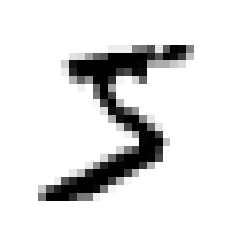

In [5]:
# let's plot one 

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
# Since the label is a string, let's cast it to int

import numpy as np

y = y.astype(np.uint8)

In [8]:
# Let's create a test set and set it aside

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifiers

In [9]:
# Let's build a binary classifier that classifies 5 or not 5
# let's start with creating the target vectors for that 

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [10]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [11]:
y_train_5

array([ True, False, False, ...,  True, False, False])

### Stochastic Gradient Descent (SGD)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
# Let's predict

sgd_clf.predict([some_digit])

array([ True])

In [14]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [16]:
# let's build a cross-validation algo to have more control 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [17]:
# Let's use K-fold CV

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [18]:
# Let's create a not 5 classifier 

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [20]:
# Let's use cross_val_predict to make the predictions based on the training set

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
# Now let's build the confusion matrix 

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [22]:
# to read the above (correct predictions are diagonal from top left to bottom right)

#   correct non - 5s           incorrect 5s
# incorrect non - 5s           correct 5s

#   true negatives             false positives
#   false negatives            true positives

In [23]:
# perfect prediction would output

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
# compute the f-score for the harmonic mean (gives more weight to low values)

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
# Let's work with the SGD threshold for precision/recall tradeoff

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0

y_some_digit_pred = (y_scores > threshold)

In [29]:
y_some_digit_pred

array([ True])

In [30]:
threshold = 8000

y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

In [31]:
# let's look at the decision scores from the cross validation

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [33]:
# Let's look at the precision recall curve 

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

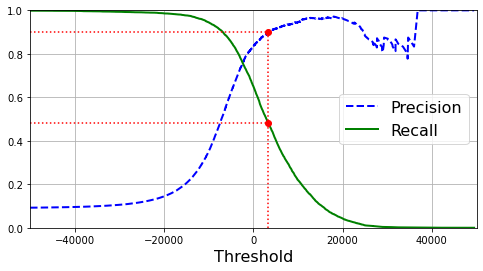

In [34]:
# Let's visualize precision and recall versus the decision threshold

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")               
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                           
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
                                         
plt.show()

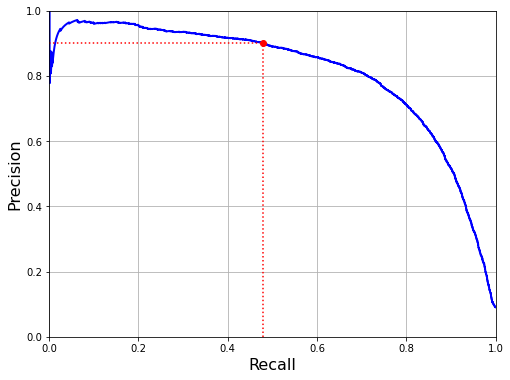

In [35]:
# Let's visualize precision versus recall (select tradeoff right before the drop)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [36]:
# to find the threshold for 90% precision 

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [37]:
threshold_90_precision

3370.0194991439594

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [41]:
# So if we increase precision (how correctly it recognizes the 5s)
# the recall drops (how many 5s its not identifying)

### ROC Curve

In [42]:
# ROC curve plots the true positive rate against (TPR) the false positive rate (FPR)
# TPR = Same as recall 
# FPR = Ratio of negative instances that are incorrectly classified as positive


from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

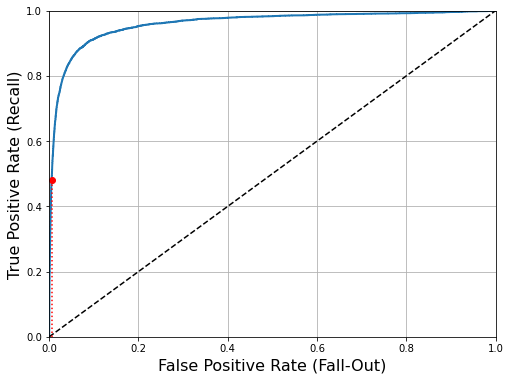

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                                 
plt.show()

In [44]:
# to read: the middle line is the ROC curve of a random classifier)
# a good classifier would be as far away as possible usually towards the top-left corner

In [45]:
# Let's computer the Area under the curve (AUC)
# Perfect is 1 and random is 0.5 

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [49]:
# usually the roc_curve() function expects labels and scores, but class probabilities can be fed as well 

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

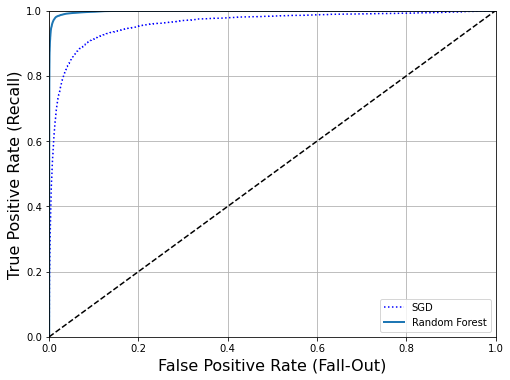

In [52]:
# Let's plot the ROC for both SGD and Random Forrest

plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [54]:
# AUC score

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [58]:
# Confusion Matrix

y_train_pred_rf = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred_rf)

array([[54534,    45],
       [  725,  4696]])

In [59]:
# Precision score 

precision_score(y_train_5, y_train_pred_rf)

0.9905083315756169

In [61]:
# Recall score

recall_score(y_train_5, y_train_pred_rf)

0.8662608374838591

# Multiclass Classification

### Support Vector Machine

In [63]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [65]:
# Under the hood, SVC uses the OvO strategy and train 45 binary classifiers
# the decision function method will return 10 scores instead of 1 

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [70]:
# max score index

np.argmax(some_digit_scores)

5

In [71]:
# how the classes are organized by value order inside the classifier 

svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [72]:
# where does the max score index lie within the classes 
# the index and the value being the same is only a conincidence

svm_clf.classes_[5]

5

### OneVsRest Classifier 

In [73]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [74]:
len(ovr_clf.estimators_)

10

### SGD Classifier 

In [75]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [78]:
# Let's look at the decision scores

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [79]:
# Let's Cross Validate

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [82]:
# Now let's scale the inputs to see if it increases the accuracy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Random Forest Classifier

In [76]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [81]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9646 , 0.96255, 0.9666 ])

### Error Analysis

In [83]:
# Let's analyze with a confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

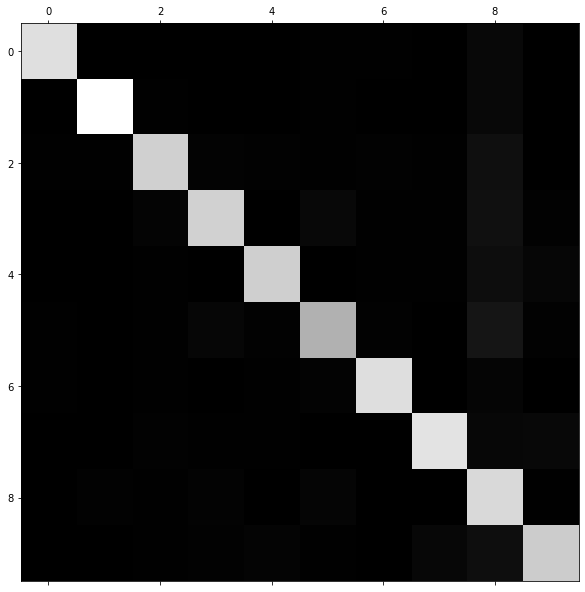

In [93]:
# plotting the matrix for visuals

plt.figure(figsize=(10, 10)) 
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1) # fignum arg is to increase the size of the plot
plt.show()

In [88]:
# Now let's look at the error rates as oppose to the absolute numbers of errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

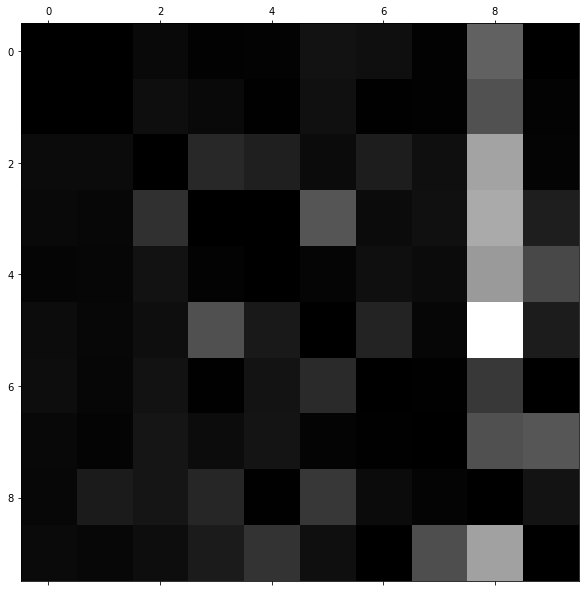

In [94]:
# Let's plot this now on a new cofusion matrix

plt.figure(figsize=(10, 10))
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

In [96]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

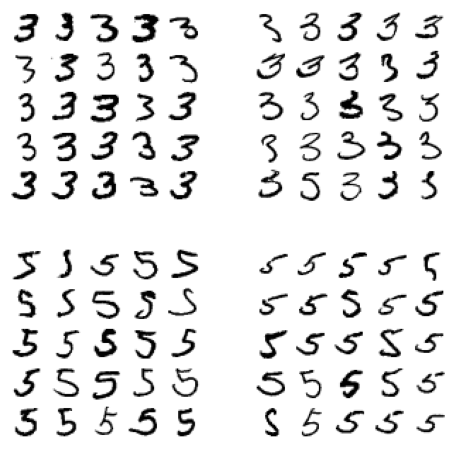

In [97]:
# to look at the 3s and 5s pictures 

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [99]:
# to read: the bottom left and top right are wrongly classified ones

# at this point, preprocessing the images to ensure they are prominent and not too rotated will help

# Multilabel Classification

### K Neighbors Classifier

In [102]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # not large (7, 8 or 9)
y_train_odd = (y_train % 2 == 1) # is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [103]:
# Let's predict 

knn_clf.predict([some_digit])

array([[False,  True]])

#### the above prediction indicates that the number is not large and is odd 

In [104]:
# Let's measure the F1 score for each individual label and average it

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel,y_train_knn_pred, average='macro')

0.976410265560605

In [105]:
# Let's measure the weighted F1 score so that a weight is assigned to its support (number of instances with that target label) 

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel,y_train_knn_pred, average='weighted')

0.9778357403921755

# Multioutput-Multiclass Classification

#### this is generalization of multilabel classification where each lavel can be multiclass

In [107]:
# Let's clean up the noise from a digit image 
# the purpose of this would be to have the classifier to have a multilabled output (one lavel per pixel)
# and each label can have multiple values (pixel intensity ranges from 0 to 255)

In [108]:
# First let's input noise in an image 

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

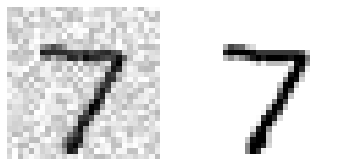

In [112]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

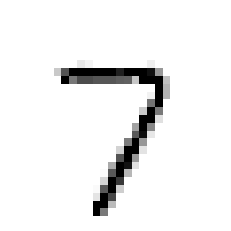

In [113]:
# Now let's train a classifier to remove the noise

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)